In [1]:
!pip install -q openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [2]:
from openai import OpenAI
import openai
import pandas as pd
# from IPython.display import display
import os

In [3]:

api_key = ""

In [4]:
client = OpenAI(api_key=api_key)

In [5]:
def classify_text(text, model="gpt-3.5-turbo", max_tokens=50):
    response = client.chat.completions.create(
      model=model,
      response_format={ "type": "json_object" },
      messages = [
        {"role": "system", "content": "You are a helpful assistant designed to output JSON with categores 'SDOH label' and 'Adverse Label'"},
        {"role": "user", "content": f"Classify the following text into one of the following SDoH categories ('Employment', 'Housing', 'Transportation', 'Parental Status', 'Relationship', 'Social Support') and identify if it is Adverse or Non-Adverse:\n\nText: \"{text}\"?"},
      ],
      max_tokens=max_tokens,
      temperature=0.5,
      n=1
    )
    return response

In [9]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/Iteration__1.csv')
train_df, data = train_test_split(data, test_size=0.2, random_state=42)
# Initialize columns for the predictions
data['predicted_label'] = ''
data['predicted_adverse'] = ''
tokens_used = 0

In [10]:
def normalize_keys(data_dict):
    return {k.lower(): v for k, v in data_dict.items()}

def adjust_labels(label):
    label = label.upper()
    if label == "PARENTAL STATUS":
        return "PARENT"
    if label == "SOCIAL SUPPORT":
        return "SUPPORT"
    if label not in ["EMPLOYMENT", "HOUSING", "TRANSPORTATION", "PARENT", "SUPPORT", "RELATIONSHIP"]:
        return "NONE"
    return label

def adjust_adverse(adverse):
    adverse = adverse.lower().replace("non-adverse", "nonadverse").replace("non adverse", "nonadverse")
    return adverse

In [11]:
for index, row in data.iterrows():
    prediction = classify_text(row['text'])
    prediction_dict = prediction.choices[0].message.content
    tokens_used += prediction.usage.total_tokens
    prediction_dict = eval(prediction_dict)
    # print(prediction_dict)
    normalized_prediction = normalize_keys(prediction_dict)  # Converting string representation of dictionary back to
    if type(normalized_prediction['sdoh label']) == list:
        normalized_prediction['sdoh label'] = normalized_prediction['sdoh label'][0]
    adjusted_label = adjust_labels(normalized_prediction['sdoh label'])
    adjusted_adverse = adjust_adverse(normalized_prediction['adverse label'])

    data.at[index, 'predicted_label'] = adjusted_label
    data.at[index, 'predicted_adverse'] = adjusted_adverse



In [12]:
print(tokens_used)

23618


In [13]:
data.to_csv('/content/sdoh_test_output.csv', index=False)


In [14]:
# text = "Patient recently moved into an apartment but is experiencing issues with pests such as bed bugs and roaches"
# c = classify_text(text)
# for i in c:
#   print(i)
# print(c.usage.total_tokens)
# print(c.choices[0].message.content)

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
data = pd.read_csv('/content/sdoh_test_output.csv')

In [17]:
# Calculate accuracies
sdoh_accuracy = accuracy_score(data['label'], data['predicted_label'])
adverse_accuracy = accuracy_score(data['adverse'], data['predicted_adverse'])

print(f"SDOH Label Accuracy: {sdoh_accuracy * 100:.2f}%")
print(f"Adverse Label Accuracy: {adverse_accuracy * 100:.2f}%")


SDOH Label Accuracy: 83.89%
Adverse Label Accuracy: 72.78%


In [18]:
# code to save incorrect predictions to a CSV file

# # Add columns for incorrect predictions
# data['incorrect_sdoh'] = data['label'] != data['predicted_label']
# data['incorrect_adverse'] = data['adverse'] != data['predicted_adverse']
# # Filter to get only incorrect predictions
# incorrect_predictions = data[(data['incorrect_sdoh']) | (data['incorrect_adverse'])]

# print(f"Total incorrect predictions: {len(incorrect_predictions)}")
# incorrect_predictions.to_csv('/content/incorrect_predictions.csv', index=False)

In [19]:
# Calculate confusion matrices

adverse_cm = confusion_matrix(data['adverse'], data['predicted_adverse'])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



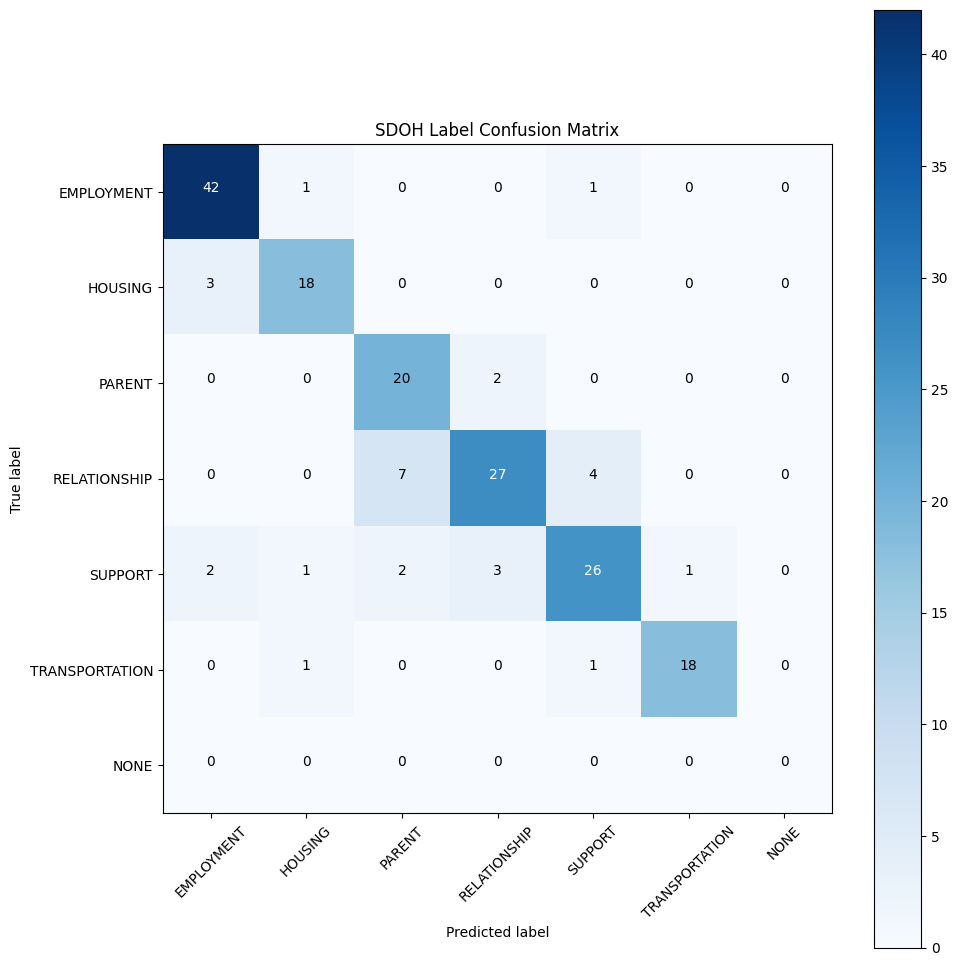

In [20]:
# Plotting confusion matrices
# For SDOH_LABEL
unique_sdoh_labels = sorted(data['label'].unique())
unique_sdoh_labels.append('NONE')
sdoh_cm = confusion_matrix(data['label'], data['predicted_label'], labels=unique_sdoh_labels)
plot_confusion_matrix(sdoh_cm, classes=unique_sdoh_labels, title='SDOH Label Confusion Matrix')
plt.show()



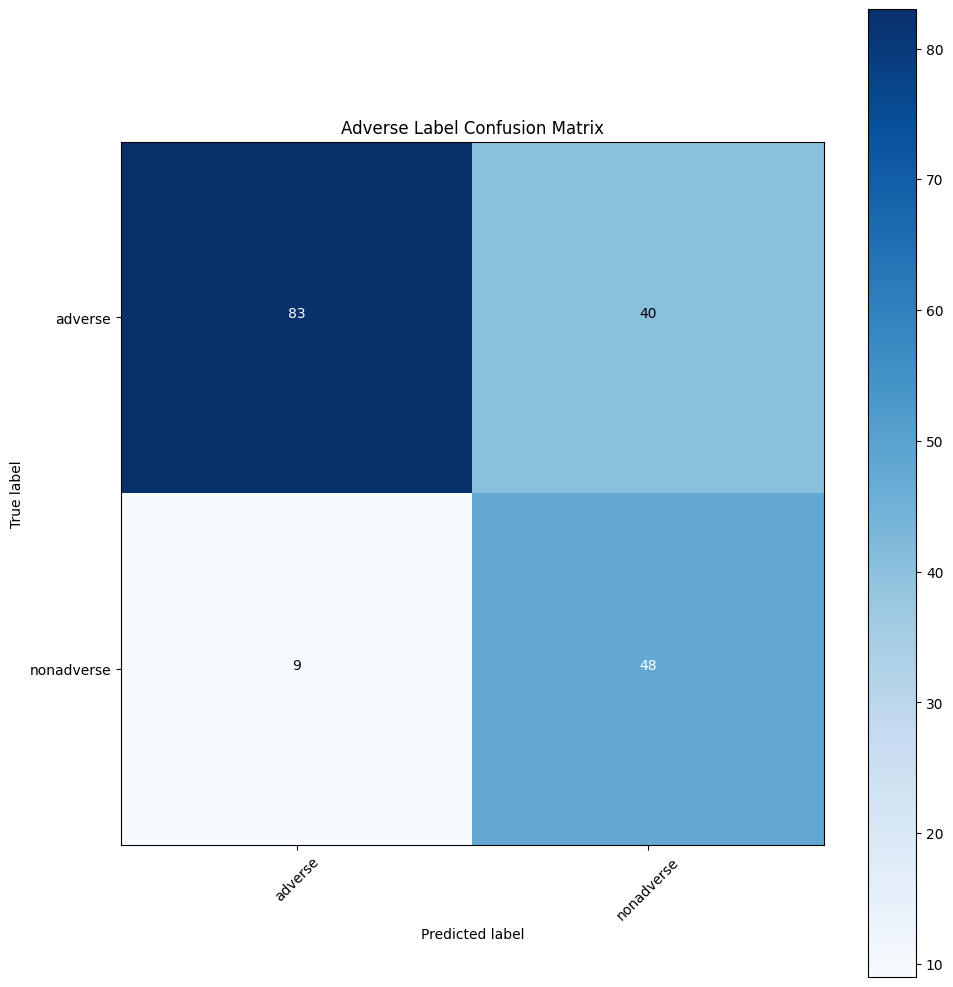

In [21]:
# For ADVERSE_LABEL
unique_adverse_labels = sorted(data['adverse'].unique())
adverse_cm = confusion_matrix(data['adverse'], data['predicted_adverse'],labels = unique_adverse_labels)
plot_confusion_matrix(adverse_cm, classes=unique_adverse_labels, title='Adverse Label Confusion Matrix')
plt.show()

#Testing on augmented MTS Dataset

In [30]:
data = pd.read_csv('/content/augmented_mts.csv')
# Initialize columns for the predictions
data['predicted_label'] = ''
data['predicted_adverse'] = ''

In [31]:

for index, row in data.iterrows():
    prediction = classify_text(row['section_text'])
    prediction_dict = prediction.choices[0].message.content
    tokens_used += prediction.usage.total_tokens
    prediction_dict = eval(prediction_dict)
    # print(prediction_dict)
    normalized_prediction = normalize_keys(prediction_dict)
    if type(normalized_prediction['sdoh label']) == list:
        normalized_prediction['sdoh label'] = normalized_prediction['sdoh label'][0]
    adjusted_label = adjust_labels(normalized_prediction['sdoh label'])
    adjusted_adverse = adjust_adverse(normalized_prediction['adverse label'])

    data.at[index, 'predicted_label'] = adjusted_label
    data.at[index, 'predicted_adverse'] = adjusted_adverse

In [32]:
data['Adverse Category'] = data['Adverse Category'].str.replace('non-adverse', 'nonadverse', regex=False)
data = data[data['predicted_adverse'].isin(['adverse', 'nonadverse'])]
data.to_csv('/content/mts_output.csv', index=False)


In [33]:
data = pd.read_csv('/content/mts_output.csv')

In [34]:
# Calculate accuracies
sdoh_accuracy = accuracy_score(data['SDOH label'], data['predicted_label'])
adverse_accuracy = accuracy_score(data['Adverse Category'], data['predicted_adverse'])
print("Accuracy on augmented MTS dataset")
print(f"SDOH Label Accuracy: {sdoh_accuracy * 100:.2f}%")
print(f"Adverse Label Accuracy: {adverse_accuracy * 100:.2f}%")

Accuracy on augmented MTS dataset
SDOH Label Accuracy: 67.50%
Adverse Label Accuracy: 61.00%


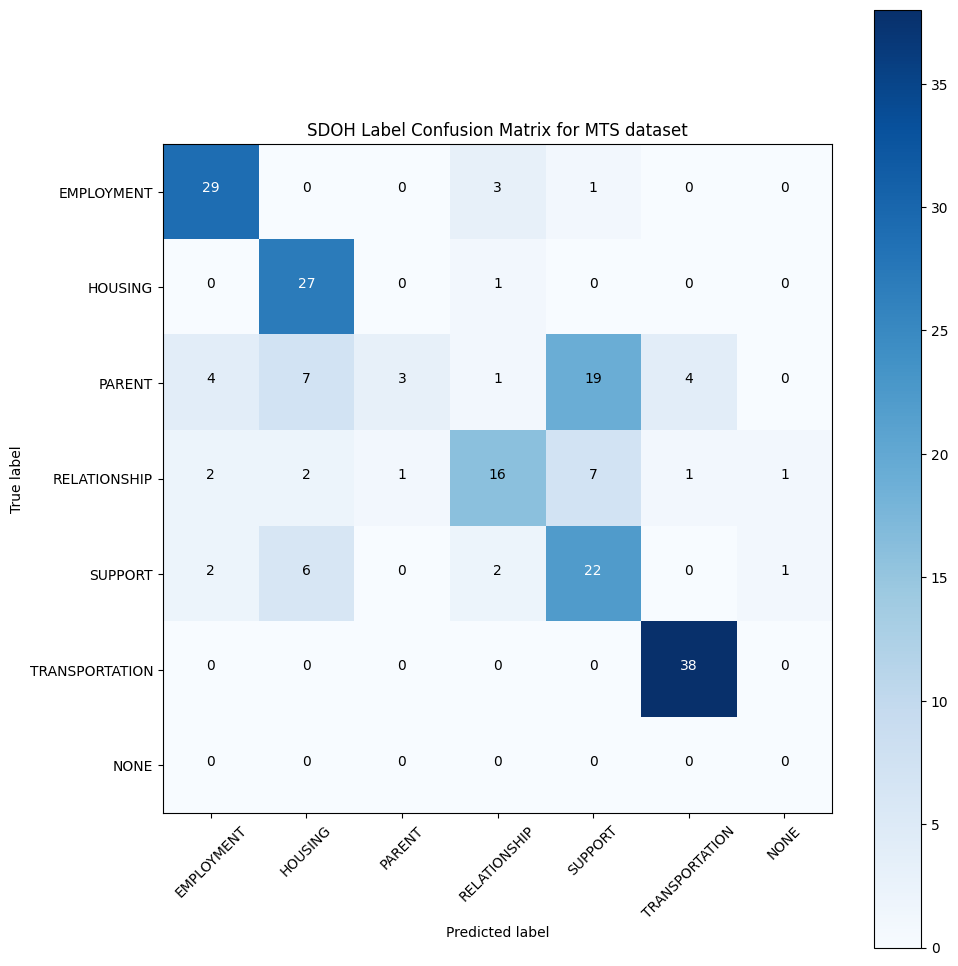

In [35]:
# Plotting confusion matrices
# For SDOH_LABEL
unique_sdoh_labels = sorted(data['SDOH label'].unique())
unique_sdoh_labels.append('NONE')
sdoh_cm = confusion_matrix(data['SDOH label'], data['predicted_label'], labels=unique_sdoh_labels)
plot_confusion_matrix(sdoh_cm, classes=unique_sdoh_labels, title='SDOH Label Confusion Matrix for MTS dataset')
plt.show()

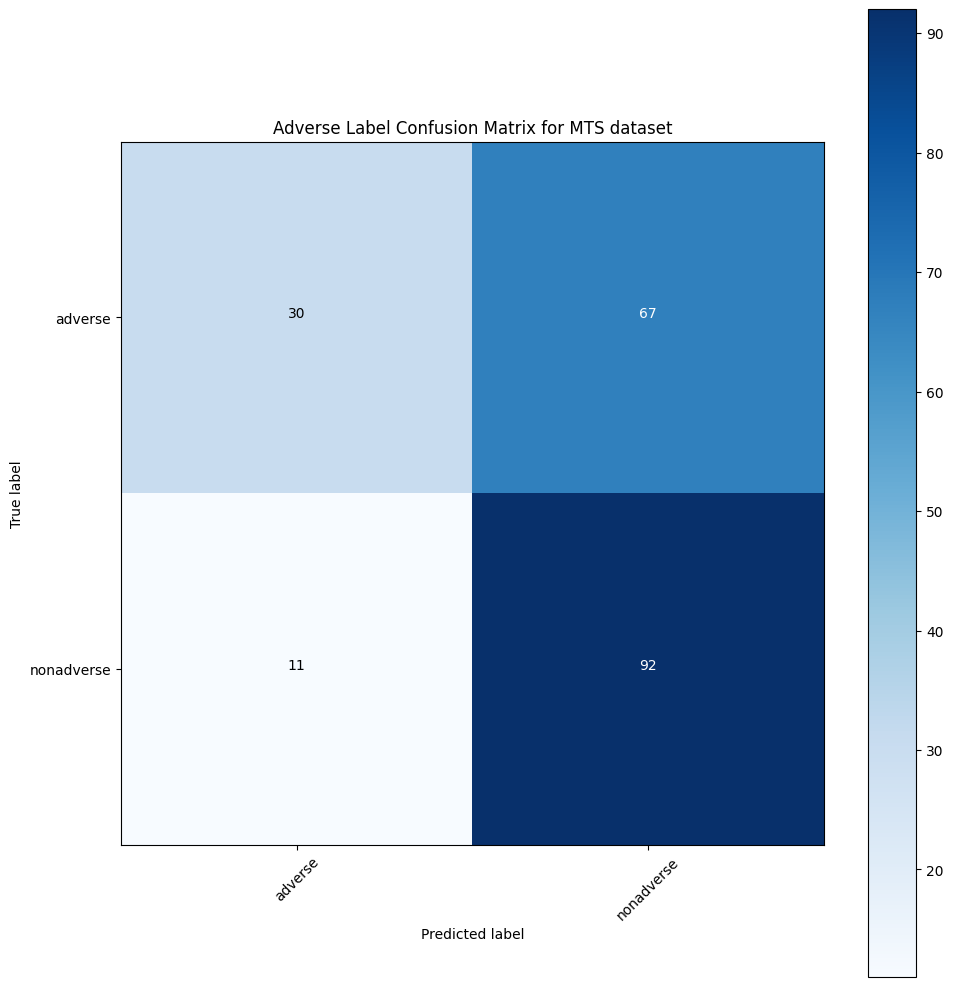

In [36]:
# For ADVERSE_LABEL
# For ADVERSE_LABEL
unique_adverse_labels = sorted(data['Adverse Category'].unique())
adverse_cm = confusion_matrix(data['Adverse Category'], data['predicted_adverse'],labels = unique_adverse_labels)

plot_confusion_matrix(adverse_cm, classes=unique_adverse_labels, title='Adverse Label Confusion Matrix for MTS dataset')
plt.show()